## Imports

In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import Funciones_EDA as EDA

from sklearn.metrics import silhouette_score, silhouette_samples, precision_recall_fscore_support
import pingouin as pg
from factor_analyzer import FactorAnalyzer
import statsmodels.api as sm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

path='C:/Repo/MiM_Analytics_Tesis/Tesis/'
#path='C:/Users/E0662122/Repo/MiM_Analytics_Tesis/Tesis/'

In [2]:
postgreSQL = {"host": "localhost", "port": "5432", "username": "postgres", 
               "password": "trivisono", "database": "SportsAnalytics"}

uri = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(postgreSQL['username'], postgreSQL['password'], postgreSQL['host'], postgreSQL['port'], postgreSQL['database'])

engine = create_engine(uri)
conn = engine.raw_connection()
cursor = conn.cursor()

In [3]:
df_perf_index = pd.read_sql_query("SELECT * FROM fdm.dash_ft_abt_season_players_train;", conn)

rating_correction = pd.read_sql_query("SELECT player_id, \
    SUM(player_rating*player_minutes)/NULLIF(SUM(CASE WHEN player_rating=0 THEN 0 ELSE player_minutes END), 0) wavg_player_rating \
    FROM fdm.ft_api_matches_stats_players AS stats_players GROUP BY player_id \
    HAVING SUM(player_rating*player_minutes)/NULLIF(SUM(CASE WHEN player_rating=0 THEN 0 ELSE player_minutes END), 0) IS NOT NULL", conn)

In [4]:
df = df_perf_index.copy()

## Preprocessing

In [5]:
df = df[(df['player_minutes']>=270) & (df['player_id']>0)].copy()

In [6]:
## Per 90 stats
# Attacking
df['offsides_p90'] = df['offsides']/df['player_minutes']*90
df['shots_p90'] = df['shots_total']/df['player_minutes']*90
df['shooting_accuracy'] = np.where(df['shots_total']==0, 0, np.where(df['shots_total']<df['shots_on_goal'], 1,
                                                                     df['shots_on_goal']/df['shots_total']))
df['goals_p90'] = df['goals_total']/df['player_minutes']*90
df['np_goals_p90'] = np.where(df['goals_total']-df['penalty_scored']<0, 0, 
                              (df['goals_total']-df['penalty_scored'])/df['player_minutes']*90)
df['goal_conversion'] = np.where(df['shots_total']==0, 0, df['goals_total']/df['shots_total'])
df['goal_conversion_np'] = np.where(df['shots_total']==0, 0, (df['goals_total']-df['penalty_scored'])/df['shots_total'])
df['assists_p90'] = df['goals_assists']/df['player_minutes']*90
df['penalty_won_p90'] = df['penalty_won']/df['player_minutes']*90
df['penalty_missed_p90'] = df['penalty_missed']/df['player_minutes']*90

# Build-up
df['passes_p90'] = df['passes_total']/df['player_minutes']*90
df['passing_accuracy'] = np.where(df['passes_total']==0, 0, df['passes_completed']/df['passes_total'])
df['key_passes_p90'] = df['passes_key']/df['player_minutes']*90
df['fouls_drawn_p90'] = df['fouls_drawn']/df['player_minutes']*90

# Defense
df['tackles_p90'] = df['tackles_total_padj']/df['player_minutes']*90
df['blocks_p90'] = df['tackles_blocks_padj']/df['player_minutes']*90
df['interceptions_p90'] = df['tackles_interceptions_padj']/df['player_minutes']*90
df['saves_p90'] = df['goals_saves_padj']/df['player_minutes']*90
df['penalty_saves_p90'] = df['penalty_saved']/df['player_minutes']*90
df['penalty_committed_p90'] = df['penalty_committed_padj']/df['player_minutes']*90
df['goals_conceded_p90'] = df['goals_conceded_padj']/df['player_minutes']*90
df['shots_on_goal_opp_p90'] = df['shots_on_goal_opp_padj']/df['player_minutes']*90
df['goals_conceded_ratio'] = df['goals_conceded_p90']/df['shots_on_goal_opp_p90']
df['fouls_committed_p90'] = df['fouls_committed_padj']/df['player_minutes']*90

# One vs one
df['duels_p90'] = df['duels_total_padj']/df['player_minutes']*90
df['duels_success_ratio'] = np.where(df['duels_total_padj']==0, 0, df['duels_won_padj']/df['duels_total_padj'])
df['dribbles_p90'] = df['dribbles_attemps']/df['player_minutes']*90
df['dribbles_success_ratio'] = np.where(df['dribbles_attemps']==0, 0, df['dribbles_success']/df['dribbles_attemps'])
df['dribbles_past_p90'] = df['dribbles_past_padj']/df['player_minutes']*90

# General
df['cards_yellow_p90'] = df['cards_yellow']/df['player_minutes']*90
df['cards_red_p90'] = df['cards_red']/df['player_minutes']*90

# Combined
df['scoring_contribution'] = df['np_goals_p90']+df['assists_p90']

In [7]:
# Fill NAs rating with ratings from the same players in other seasons
df = df.merge(rating_correction, on=['player_id'], how='left')
df['wavg_player_rating'] = np.where(df['wavg_player_rating_x'].isna(), df['wavg_player_rating_y'], df['wavg_player_rating_x'])
del df['wavg_player_rating_x'], df['wavg_player_rating_y']

# Fill NAs rating with average rating of the position in the entire dataset
df_ratings_pos = df[['player_preferred_position', 'wavg_player_rating']].groupby(['player_preferred_position']).median().rename(
    columns={'wavg_player_rating': 'wavg_position_rating'}).reset_index()
df = df.merge(df_ratings_pos, on=['player_preferred_position'], how='left')
df['wavg_player_rating'] = np.where(df['wavg_player_rating'].isna(), df['wavg_position_rating'], df['wavg_player_rating'])
del df['wavg_position_rating']

In [8]:
player_cols = ['player_id', 'player_name', 'player_preferred_position', 'player_preferred_number', 'player_minutes']

fw_cols = ['np_goals_p90', 'shots_p90', 'shooting_accuracy', 'goal_conversion_np', 'passing_accuracy', 'assists_p90', 
           'key_passes_p90', 'dribbles_p90', 'dribbles_success_ratio', 'scoring_contribution', 
           'tackles_p90', 'interceptions_p90', 'avg_team_position', 'avg_league_cov'] # , 'tackles_p90', 

mf_cols = ['wavg_player_rating', 'passes_p90', 'passing_accuracy', 'key_passes_p90', 'scoring_contribution', 'dribbles_success_ratio', 
           'fouls_drawn_p90', 'fouls_committed_p90', 'dribbles_past_p90', 'tackles_p90',  'interceptions_p90', 'avg_team_position', 'avg_league_cov']

df_cols = ['wavg_player_rating', 'passes_p90', 'passing_accuracy', 'key_passes_p90', 'fouls_drawn_p90', 'fouls_committed_p90', 'dribbles_past_p90', 
           'duels_p90', 'duels_success_ratio', 'tackles_p90', 'blocks_p90', 'interceptions_p90', 'avg_team_position', 'avg_league_cov', 'penalty_committed_p90']

gk_cols = ['wavg_player_rating', 'saves_p90', 'goals_conceded_p90', 'goals_conceded_ratio', 'passes_p90', 'passing_accuracy', 'fouls_drawn_p90', 'fouls_committed_p90', 
           'duels_p90', 'duels_success_ratio', 'tackles_p90', 'blocks_p90', 'interceptions_p90', 'penalty_committed_p90', 'avg_team_position', 'avg_league_cov']

## EDA

### Forwards

In [9]:
cols_eda = fw_cols
df_eda = df[df['player_preferred_position'] == 'F'][player_cols+fw_cols]

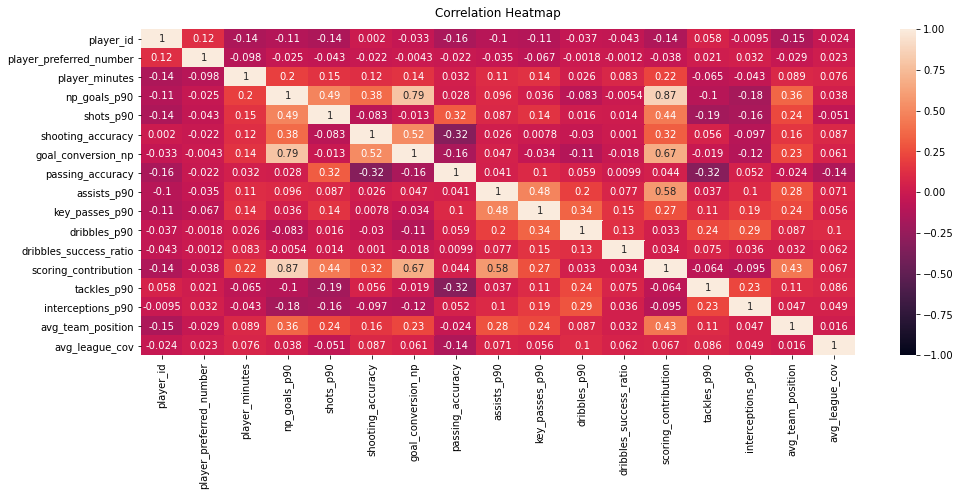

In [10]:
# Heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_eda.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [34]:
df_eda[cols_eda].describe()

,np_goals_p90,shots_p90,shooting_accuracy,goal_conversion_np,passing_accuracy,assists_p90,key_passes_p90,dribbles_p90,dribbles_success_ratio,scoring_contribution,tackles_p90,interceptions_p90,avg_team_position,avg_league_cov
count,5408.00,5408.00,5408.00,5408.00,5408.00,5408.00,5408.00,5408.00,5408.00,5408.00,5408.00,5408.00,5408.00,5408.00
mean,0.28,2.27,0.42,0.12,0.51,0.12,1.15,2.12,0.50,0.40,0.61,0.39,0.41,0.42
std,0.21,0.87,0.14,0.09,0.30,0.13,0.58,1.43,0.18,0.25,0.59,0.34,0.27,0.08
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22
25%,0.13,1.67,0.33,0.06,0.09,0.00,0.77,1.07,0.41,0.23,0.10,0.16,0.21,0.36
50%,0.25,2.19,0.41,0.12,0.67,0.10,1.06,1.79,0.50,0.37,0.50,0.31,0.37,0.42
75%,0.39,2.79,0.50,0.17,0.74,0.19,1.43,2.87,0.61,0.54,0.92,0.54,0.58,0.47
max,1.59,6.99,1.00,0.67,0.91,1.16,5.93,10.67,1.00,1.78,5.19,3.61,1.00,0.77


In [41]:
import pandas_profiling as pp

pp.ProfileReport(df_eda[cols_eda]).to_file("EDA_Forwards.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
df[df['avg_league_cov'] < 0.25]

,league_season,player_id,player_name,player_preferred_position,player_preferred_number,team_id,team_name,team_country,avg_team_position,avg_league_cov,player_minutes,offsides,shots_total,shots_on_goal,goals_total,goals_conceded_padj,shots_on_goal_opp_padj,goals_assists,goals_saves_padj,passes_total,passes_key,passes_completed,tackles_total_padj,tackles_blocks_padj,tackles_interceptions_padj,duels_total_padj,duels_won_padj,dribbles_attemps,dribbles_success,dribbles_past_padj,fouls_drawn,fouls_committed_padj,cards_yellow,cards_red,penalty_won,penalty_committed_padj,penalty_scored,penalty_missed,penalty_saved,offsides_p90,shots_p90,shooting_accuracy,goals_p90,np_goals_p90,goal_conversion,goal_conversion_np,assists_p90,penalty_won_p90,penalty_missed_p90,passes_p90,passing_accuracy,key_passes_p90,fouls_drawn_p90,tackles_p90,blocks_p90,interceptions_p90,saves_p90,penalty_saves_p90,penalty_committed_p90,goals_conceded_p90,shots_on_goal_opp_p90,goals_conceded_ratio,fouls_committed_p90,duels_p90,duels_success_ratio,dribbles_p90,dribbles_success_ratio,dribbles_past_p90,cards_yellow_p90,cards_red_p90,scoring_contribution,wavg_player_rating
4480,2017,71,Luan Peres,D,4,139,Ponte Preta,Brazil,0.08,0.23,1239,0,3,1,0,0.00,73.04,0,0.00,355,4,287.71,0.00,0.00,24.77,89.27,44.45,2,2,7.79,6,10.89,3,0,0,0.00,0,0,0,0.00,0.22,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,25.79,0.81,0.29,0.44,0.00,0.00,1.80,0.00,0.00,0.00,0.00,5.31,0.00,0.79,6.48,0.50,0.15,1.00,0.57,0.22,0.00,0.00,6.83
4515,2017,150,Arthur,M,29,130,Gremio,Brazil,0.75,0.23,2190,0,11,3,1,0.00,96.55,0,0.00,1867,22,1736.29,0.00,0.00,32.70,241.06,156.94,18,16,20.72,60,22.79,3,0,0,0.00,0,0,0,0.00,0.45,0.27,0.04,0.04,0.09,0.09,0.00,0.00,0.00,76.73,0.93,0.90,2.47,0.00,0.00,1.34,0.00,0.00,0.00,0.00,3.97,0.00,0.94,9.91,0.65,0.74,0.89,0.85,0.12,0.00,0.04,7.19
4642,2017,372,Eder Militao,D,13,126,Sao Paulo,Brazil,0.33,0.23,1713,0,13,5,2,0.00,105.58,0,0.00,701,4,574.11,0.00,0.00,53.15,239.47,145.71,18,10,8.90,29,28.28,1,1,0,0.00,0,0,0,0.00,0.68,0.38,0.11,0.11,0.15,0.15,0.00,0.00,0.00,36.83,0.82,0.21,1.52,0.00,0.00,2.79,0.00,0.00,0.00,0.00,5.55,0.00,1.49,12.58,0.61,0.95,0.56,0.47,0.05,0.05,0.11,7.00
4643,2017,374,Joao Pedro,D,2,132,Chapecoense-sc,Brazil,0.50,0.23,484,0,10,3,0,0.00,27.03,0,0.00,125,4,90.15,0.00,0.00,1.74,61.97,20.76,23,8,4.26,4,5.60,1,0,0,0.00,0,0,0,0.00,1.86,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.24,0.72,0.74,0.74,0.00,0.00,0.32,0.00,0.00,0.00,0.00,5.03,0.00,1.04,11.52,0.33,4.28,0.35,0.79,0.19,0.00,0.00,6.29
4783,2017,687,Maycon,M,8,131,Corinthians,Brazil,1.00,0.23,2683,0,37,8,1,0.00,141.01,2,0.00,1498,31,1310.36,0.00,0.00,49.13,229.73,100.77,16,4,32.42,17,23.85,3,0,0,0.00,0,0,0,0.00,1.24,0.22,0.03,0.03,0.03,0.03,0.07,0.00,0.00,50.25,0.87,1.04,0.57,0.00,0.00,1.65,0.00,0.00,0.00,0.00,4.73,0.00,0.80,7.71,0.44,0.54,0.25,1.09,0.10,0.00,0.10,6.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26179,2020,211807,Zacarias Lopez,G,17,2341,D. La Serena,Chile,0.11,0.22,2180,0,0,0,0,25.08,104.72,0,72.00,540,0,68.83,2.14,0.00,1.28,20.35,17.85,2,2,0.00,7,0.00,1,0,0,0.00,0,0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.29,0.13,0.00,0.29,0.09,0.00,0.05,2.97,0.04,0.00,1.04,4.32,0.24,0.00,0.84,0.88,0.08,1.00,0.00,0.04,0.00,0.00,7.06
26185,2020,237168,Bruno Gutierrez,D,4,2319,Deportes Iquique,Chile,0.00,0.22,622,0,3,0,0,0.00,51.93,0,0.00,168,4,2.88,15.62,1.16,7.61,62.04,37.68,10,6,3.39,6,6.37,1,0,0,0.00,0,0,0,0.00,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,24.31,0.02,0.58,0.87,2.26,0.17,1.10,0.00,0.00,0.00,0.00,7.51,0.00,0.92,8.98,0.61,1.45,0.60,0.49,0.14,0.00,0.00,6.87
26218,2020,277977,Gary Moya,M,5,2325,Everton de Vina,Chile,0.11,0.22,537,1,6,3,1,0.00,45.97,1,0.00,289,4,6.93,18.30,0.00,2.92,68.86,33.28,19,7,10.53,8,8.05,0,0,0,0.00,0,0,0,0.17,1.01,0

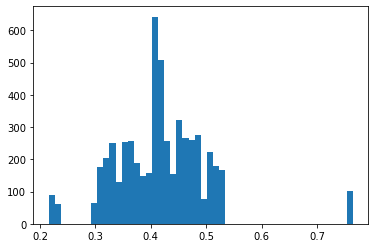

In [30]:
EDA.plot_histogram(df_eda, 'avg_league_cov')

In [11]:
df_eda.sort_values('np_goals_p90', ascending=False)

,player_id,player_name,player_preferred_position,player_preferred_number,player_minutes,np_goals_p90,shots_p90,shooting_accuracy,goal_conversion_np,passing_accuracy,assists_p90,key_passes_p90,dribbles_p90,dribbles_success_ratio,scoring_contribution,tackles_p90,interceptions_p90,avg_team_position,avg_league_cov
28767,195809,Luciano Arriagada,F,32,283,1.59,3.18,0.50,0.50,0.02,0.00,0.32,2.54,0.00,1.59,2.94,0.32,0.96,0.38
9596,21,Paco Alcacer,F,9,1201,1.27,3.90,0.54,0.33,0.66,0.00,1.12,0.60,0.75,1.27,0.06,0.46,0.96,0.52
21543,2493,Luis Muriel,F,9,1433,1.26,4.71,0.52,0.27,0.02,0.44,3.08,5.65,0.59,1.70,1.47,0.52,0.80,0.52
2108,21093,Gabriel Boschilia,F,26,437,1.24,4.12,0.55,0.30,0.76,0.41,2.06,3.30,0.81,1.65,0.00,0.98,1.00,0.43
9748,278,Kylian Mbappe,F,7,2342,1.23,4.80,0.57,0.26,0.80,0.27,1.88,4.50,0.56,1.50,0.20,0.21,1.00,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4038,79199,Alveiro Sanchez,F,21,295,0.00,1.22,0.25,0.00,0.82,0.00,0.92,2.44,0.38,0.00,0.00,1.98,0.18,0.35
23711,24811,Anthony Modeste,F,14,509,0.00,2.30,0.15,0.00,0.04,0.00,0.71,0.18,0.00,0.00,0.76,0.00,0.44,0.46
12510,20899,Nathael Julan,F,14,430,0.00,2.93,0.43,0.00,0.60,0.00,1.05,1.67,0.25,0.00,0.00,0.00,0.00,0.44
1621,11590,Gabriel Vargas,F,25,508,0.00,0.71,0.50,0.00,0.70,0.00,0.18,0.00,0.00,0.00,0.48,0.76,0.23,0.36
